<a href="https://colab.research.google.com/github/prabal5ghosh/research-project-on-physics-informed-machine-learning-on-transcriptomics-data/blob/main/pinn_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
import keras
from keras import layers

print(tf.__version__)
print(keras.__version__)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 0: Loss = 66.06360626220703
Epoch 100: Loss = 24.003042221069336
Epoch 200: Loss = 22.944149017333984
Epoch 300: Loss = 22.299835205078125
Epoch 400: Loss = 21.54697036743164
Epoch 500: Loss = 20.688331604003906
Epoch 600: Loss = 19.841533660888672
Epoch 700: Loss = 19.078115463256836
Epoch 800: Loss = 18.32584571838379
Epoch 900: Loss = 17.47959327697754
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step


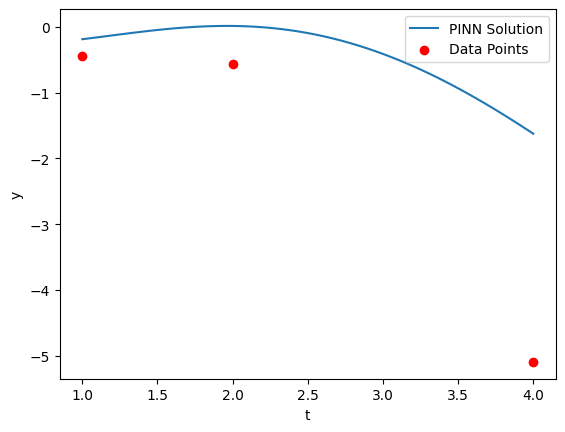

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

# Define constants
c_value = 0  # Assume c = 0 for simplicity
a_value = 0.1178 * c_value + 1.267
b_value = -2.2619 * c_value - 5.125

# Define time domain
t_min, t_max = 1, 4
t_train = np.linspace(t_min, t_max, 100).reshape(-1, 1)

# Neural network model
model = tf.keras.Sequential([
    layers.InputLayer(input_shape=(1,)),
    layers.Dense(20, activation='tanh'),
    layers.Dense(20, activation='tanh'),
    layers.Dense(1)
])

# Physics-Informed Loss function
def pinn_loss(t, y_true):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(t)
        y_pred = model(t)
        dy_dt = tape.gradient(y_pred, t)
    d2y_dt2 = tape.gradient(dy_dt, t)
    del tape
    physics = d2y_dt2 + a_value * dy_dt + b_value * y_pred - c_value
    physics_loss = tf.reduce_mean(tf.square(physics))
    boundary_loss = tf.reduce_mean(tf.square(model(np.array([[1.0]])) - -0.44796)) + \
                    tf.reduce_mean(tf.square(model(np.array([[2.0]])) - -0.56015)) + \
                    tf.reduce_mean(tf.square(model(np.array([[4.0]])) - -5.09196))
    return physics_loss + boundary_loss

# Training loop
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

@tf.function
def train_step():
    with tf.GradientTape() as tape:
        loss = pinn_loss(tf.convert_to_tensor(t_train, dtype=tf.float32), None)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

# Training the PINN
epochs = 1000
for epoch in range(epochs):
    loss = train_step()
    if epoch % 100 == 0:
        print(f"Epoch {epoch}: Loss = {loss.numpy()}")

# Predictions
t_test = np.linspace(t_min, t_max, 100).reshape(-1, 1)
y_pred = model.predict(t_test)

# Plot the result
import matplotlib.pyplot as plt
plt.plot(t_test, y_pred, label='PINN Solution')
plt.scatter([1, 2, 4], [-0.44796, -0.56015, -5.09196], color='red', label='Data Points')
plt.xlabel('t')
plt.ylabel('y')
plt.legend()
plt.show()


In [ ]:
import tensorflow as tf
import numpy as np

# Define the PINN architecture for the ODE system
class GeneExpressionPINN(tf.keras.Model):
    def __init__(self, num_layers=5, num_neurons=50):
        super(GeneExpressionPINN, self).__init__()
        self.hidden_layers = [tf.keras.layers.Dense(num_neurons, activation='tanh') for _ in range(num_layers)]
        self.output_layer = tf.keras.layers.Dense(1)

    def call(self, t, X):
        # Reshape t to match the shape of X (i.e., repeating t for each gene)
        t_reshaped = tf.reshape(t, (-1, 1))  # Shape: (3, 1)
        t_reshaped = tf.tile(t_reshaped, [1, X.shape[0]])  # Shape: (3, 5)

        # Transpose X to match the time dimension in the next step
        X_transposed = tf.transpose(X)  # Shape: (3, 5)

        # Concatenate time and gene expressions (now both have shape (3, 5))
        x = tf.concat([t_reshaped, X_transposed], axis=1)  # Shape: (3, 10)

        # Feed through hidden layers
        for layer in self.hidden_layers:
            x = layer(x)

        # Output layer
        return self.output_layer(x)

# Define ODE residual function (example: exponential decay for gene expression)
def ode_residual(model, t, X):
    dx_dt = model(t, X)  # Neural network's output

    # Define a simple ODE for gene expression: exponential decay (e.g., dx/dt = -k*x)
    k = 0.1  # decay constant (adjust as needed)
    # Reshape dx_dt to match the shape of X_transposed for subtraction
    dx_dt = tf.transpose(dx_dt) # Now shape: (5, 3) or (num_genes, num_time_points)

    X_reshaped = tf.reshape(X, [-1, 1])  # Reshape X to ensure compatibility for multiplication
    X_repeated = tf.tile(X_reshaped, [1, t.shape[0]])  # Shape: (5, 3)

    # Assume each gene decays exponentially with rate k
    dx_dt_exact = -k * X_repeated  # Shape: (5, 3)

    return tf.reduce_mean(tf.square(dx_dt - dx_dt_exact))

# Data (your provided gene expression values)
time_points = np.array([1, 2, 4])  # days
gene_data = {
    'AT2G38470': [0.906, 0.906, 0.906],
    'AT5G40100': [-0.448, -0.560, -5.092],
    'AT1G06930': [1.778, 0, 0],
    'AT1G04470': [0, 1.175, 0],
    'AT5G66730': [0.055, 0.098, -0.102]
}

# Convert to TensorFlow format
time_tensor = tf.convert_to_tensor(time_points, dtype=tf.float32)
expression_tensor = tf.convert_to_tensor(list(gene_data.values()), dtype=tf.float32)

# Initialize and train the PINN
model = GeneExpressionPINN()
optimizer = tf.optimizers.Adam()

# Training loop
for epoch in range(1000):
    with tf.GradientTape() as tape:
        loss = ode_residual(model, time_tensor, expression_tensor)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    if epoch % 100 == 0:
        print(f'Epoch {epoch}, Loss: {loss.numpy()}')

# After training, use the model to predict the gene expression for new time points
predicted_expression = model(time_tensor, expression_tensor)


Epoch 0, Loss: 0.06098169833421707
Epoch 100, Loss: 0.02230748161673546
Epoch 200, Loss: 0.022307127714157104
Epoch 300, Loss: 0.022307131439447403
Epoch 400, Loss: 0.022307131439447403
Epoch 500, Loss: 0.022307127714157104
Epoch 600, Loss: 0.022307131439447403
Epoch 700, Loss: 0.022307131439447403
Epoch 800, Loss: 0.022307127714157104
Epoch 900, Loss: 0.022307131439447403


In [ ]:
import torch
import torch.nn as nn

class ODENet(nn.Module):
    def __init__(self):
        super(ODENet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 32),
            nn.Tanh(),
            nn.Linear(32, 32),
            nn.Tanh(),
            nn.Linear(32, 5)  # Output layer with 5 neurons
        )

    def forward(self, t):
        return self.net(t)


In [ ]:
def ode_loss(model, t, y_true):
    y_pred = model(t)

    # Reshape y_pred and y_true to have the same shape
    y_pred = y_pred.transpose(0, 1)  # Transpose to shape (5, 3)

    # Data loss
    loss_data = torch.mean((y_pred - y_true)**2)

    # Physics loss (approximating derivatives)
    dt = 0.01
    t_prev = t - dt
    t_next = t + dt
    y_prev = model(t_prev)
    y_next = model(t_next)
    dy_dt = (y_next - y_prev) / (2 * dt)

    # Define your ODE here (example: dy/dt = -y)
    # NOTE: You may need to adjust this part to match your actual ODE
    ode_residual = dy_dt + y_pred.transpose(0, 1)  # Transpose back for physics loss calculation
    loss_physics = torch.mean(ode_residual**2)

    return loss_data + loss_physics

In [ ]:
import numpy as np

# Prepare data
data = np.array([
    [0.906000416, 0.906000416, 0.906000416],
    [-0.44796003, -0.560154646, -5.091964284],
    [1.778358524, 0, 0],
    [0, 1.175149691, 0],
    [0.055374646, 0.098434984, -0.101756864]
])
t_data = torch.tensor([1, 2, 4], dtype=torch.float32).unsqueeze(1)
y_data = torch.tensor(data, dtype=torch.float32)

model = ODENet()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(10000):
    optimizer.zero_grad()
    loss = ode_loss(model, t_data, y_data)
    loss.backward()
    optimizer.step()

    if epoch % 1000 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")


Epoch 0, Loss: 2.840717315673828
Epoch 1000, Loss: 0.004493011627346277
Epoch 2000, Loss: 3.104556162725203e-05
Epoch 3000, Loss: 3.4071561572091014e-08
Epoch 4000, Loss: 4.015223709075144e-08
Epoch 5000, Loss: 7.315097860782771e-08
Epoch 6000, Loss: 1.9755521663000764e-08
Epoch 7000, Loss: 5.38489839527756e-05
Epoch 8000, Loss: 0.00013225345173850656
Epoch 9000, Loss: 1.0314930420918245e-07


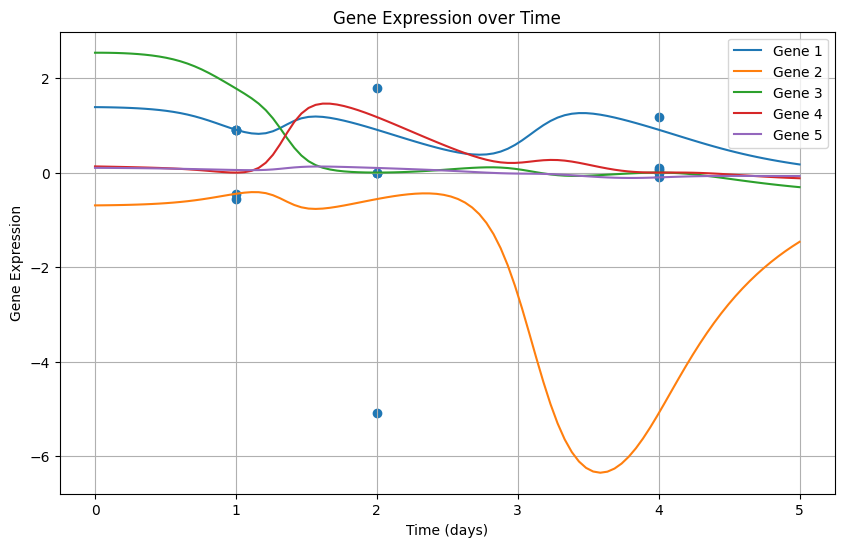

In [ ]:
import matplotlib.pyplot as plt

t_plot = torch.linspace(0, 5, 100).unsqueeze(1)
y_plot = model(t_plot).detach().numpy()

plt.figure(figsize=(10, 6))
for i in range(5):
    plt.plot(t_plot, y_plot[:, i], label=f"Gene {i+1}")

# Repeat t_data for each gene and flatten y_data
t_scatter = np.repeat(t_data.numpy().squeeze(), y_data.shape[0])
y_scatter = y_data.numpy().flatten()

plt.scatter(t_scatter, y_scatter, marker='o')  # Updated scatter plot
plt.xlabel("Time (days)")
plt.ylabel("Gene Expression")
plt.legend()
plt.title("Gene Expression over Time")
plt.grid(True)
plt.show()

In [ ]:
import tensorflow as tf
import numpy as np

# Data
time_points = np.array([1, 2, 4], dtype=np.float32).reshape(-1, 1)  # Time in days
expression_values = np.array([0.906000416, 0.906000416, 0.906000416], dtype=np.float32).reshape(-1, 1)

# Define the PINN model
class ODE_PINN(tf.keras.Model):
    def __init__(self):
        super(ODE_PINN, self).__init__()
        self.hidden_layers = [tf.keras.layers.Dense(50, activation='tanh') for _ in range(5)]
        self.output_layer = tf.keras.layers.Dense(1)  # Predict x(t)
        self.k = tf.Variable(0.1, trainable=True, dtype=tf.float32)  # Learnable parameter k

    def call(self, t):
        x = t
        for layer in self.hidden_layers:
            x = layer(x)
        return self.output_layer(x)

# Define loss function
def loss_fn(model, t, x_true):
    t = tf.convert_to_tensor(t)  # Convert t to a TensorFlow tensor
    x_pred = model(t)  # Predicted x(t)
    with tf.GradientTape() as tape:
        tape.watch(t)
        x_t = model(t)
    dx_dt = tape.gradient(x_t, t)  # Compute dx/dt
    k = model.k
    x_steady = tf.constant(0.906, dtype=tf.float32)  # Assuming steady-state value
    ode_residual = dx_dt + k * (x_t - x_steady)
    return tf.reduce_mean(tf.square(ode_residual)) + tf.reduce_mean(tf.square(x_pred - x_true))


# Prepare training
model = ODE_PINN()
optimizer = tf.optimizers.Adam()

# Training loop
epochs = 1000
for epoch in range(epochs):
    with tf.GradientTape() as tape:
        loss = loss_fn(model, time_points, expression_values)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.numpy()}")

# Display the learned parameter k
print(f"Learned decay constant k: {model.k.numpy()}")

# Predict x(t) using the trained PINN
predicted_values = model(time_points)
print("Predicted Values:", predicted_values.numpy())


Epoch 0, Loss: 1.9628865718841553
Epoch 100, Loss: 0.0006397541146725416
Epoch 200, Loss: 6.584434595424682e-05
Epoch 300, Loss: 3.8334888813551515e-05
Epoch 400, Loss: 2.187471545767039e-05
Epoch 500, Loss: 1.2387660717649851e-05
Epoch 600, Loss: 7.572311005787924e-06
Epoch 700, Loss: 5.394518666435033e-06
Epoch 800, Loss: 4.492435891734203e-06
Epoch 900, Loss: 4.123608960071579e-06
Learned decay constant k: 0.10000000149011612
Predicted Values: [[0.90747964]
 [0.90344304]
 [0.90709406]]


In [ ]:
import tensorflow as tf
import numpy as np

# Data
time_points = np.array([1, 2, 4], dtype=np.float32).reshape(-1, 1)  # Time in days
expression_values = np.array([
    [0.906000416, 0.906000416, 0.906000416],    # AT2G38470
    [-0.44796003, -0.560154646, -5.091964284],  # AT5G40100
    [1.778358524, 0, 0],                        # AT1G06930
    [0, 1.175149691, 0],                        # AT1G04470
    [0.055374646, 0.098434984, -0.101756864],   # AT5G66730
    [0.505, 0.505, 0.505],                      # AT2G38471
], dtype=np.float32)

# Number of genes
num_genes = expression_values.shape[0]

# Define the PINN model for multiple genes
class MultiGeneODE_PINN(tf.keras.Model):
    def __init__(self, num_genes):
        super(MultiGeneODE_PINN, self).__init__()
        self.num_genes = num_genes
        self.hidden_layers = [tf.keras.layers.Dense(50, activation='tanh') for _ in range(5)]
        self.output_layer = tf.keras.layers.Dense(num_genes)  # Predict x(t) for all genes
        self.k = tf.Variable(tf.random.uniform([num_genes], 0.1, 1.0), trainable=True, dtype=tf.float32)  # Learnable parameters k for each gene

    def call(self, t):
        x = t
        for layer in self.hidden_layers:
            x = layer(x)
        return self.output_layer(x)

# Define loss function
def loss_fn(model, t, x_true):
    t = tf.convert_to_tensor(t, dtype=tf.float32)  # Ensure t is a TensorFlow tensor
    x_pred = model(t)  # Predicted x(t) for all genes

    with tf.GradientTape() as tape:
        tape.watch(t)
        x_t = model(t)  # Recompute x(t) under the tape
    dx_dt = tape.gradient(x_t, t)  # Compute dx/dt for all genes

    k = tf.expand_dims(model.k, axis=0)  # Expand dims to match batch size
    x_steady = tf.constant(expression_values[:, -1], dtype=tf.float32)  # Steady-state values from the last time point
    x_steady = tf.expand_dims(x_steady, axis=0)  # Expand dims to match batch size

    ode_residual = dx_dt + k * (x_t - x_steady)  # Residual for each gene

    # Combined loss: ODE residual + Data fitting
    return tf.reduce_mean(tf.square(ode_residual)) + tf.reduce_mean(tf.square(x_pred - x_true))

# Prepare training
model = MultiGeneODE_PINN(num_genes=num_genes)
optimizer = tf.optimizers.Adam(learning_rate=0.01)

# Training loop
epochs = 300
for epoch in range(epochs):
    with tf.GradientTape() as tape:
        loss = loss_fn(model, time_points, expression_values.T)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.numpy()}")

# Display the learned parameters k
print(f"Learned decay constants k: {model.k.numpy()}")

# Predict x(t) using the trained PINN
predicted_values = model(time_points).numpy()
print("Predicted Values:\n", predicted_values)


Epoch 0, Loss: 3.262493133544922
Epoch 100, Loss: 0.40018343925476074
Epoch 200, Loss: 0.3948259949684143
Learned decay constants k: [0.58500123 0.5124133  0.8344366  0.5212426  0.7251367  0.6896312 ]
Predicted Values:
 [[ 1.2032522e+00 -1.1358970e+00  1.3821652e+00  2.8010258e-01
   3.2409737e-01  8.2261866e-01]
 [ 1.1468748e+00 -1.2792391e+00  2.7368844e-01  1.1502681e+00
   2.9342303e-01  7.6453888e-01]
 [ 9.0583354e-01 -5.0920839e+00 -1.6356260e-04 -2.4212524e-04
  -1.0198407e-01  5.0472075e-01]]


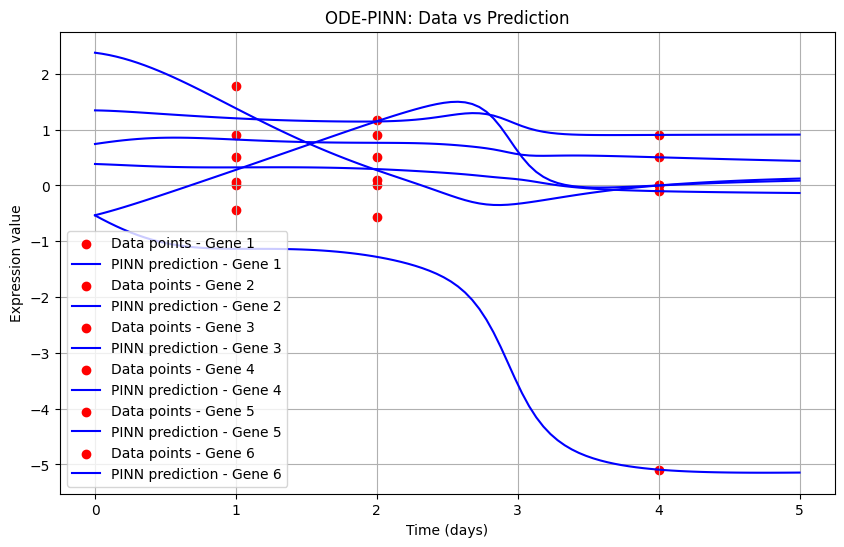

In [ ]:
import matplotlib.pyplot as plt

# Generate a range of time points for smooth curve
t_smooth = np.linspace(0, 5, 100).reshape(-1, 1)

# Get predictions for the smooth curve
x_smooth = model(t_smooth).numpy()

# Plot
plt.figure(figsize=(10, 6))

# Loop through each gene and plot its data and prediction
for i in range(num_genes):
    plt.scatter(time_points, expression_values[i], color='red', label=f'Data points - Gene {i+1}')
    plt.plot(t_smooth, x_smooth[:, i], color='blue', label=f'PINN prediction - Gene {i+1}')

plt.xlabel('Time (days)')
plt.ylabel('Expression value')
plt.title('ODE-PINN: Data vs Prediction')
plt.legend()
plt.grid(True)

plt.show()

Test Predictions (Predicted):
[[ 1.2032522e+00 -1.1358970e+00  1.3821652e+00  2.8010258e-01
   3.2409737e-01  8.2261866e-01]
 [ 1.1468748e+00 -1.2792391e+00  2.7368844e-01  1.1502681e+00
   2.9342303e-01  7.6453888e-01]
 [ 9.0583354e-01 -5.0920839e+00 -1.6356260e-04 -2.4212524e-04
  -1.0198407e-01  5.0472075e-01]]

Test Data (Actual):
[[0.9 0.7 0. ]
 [0.5 0.7 0.5]
 [0.  0.7 0. ]]


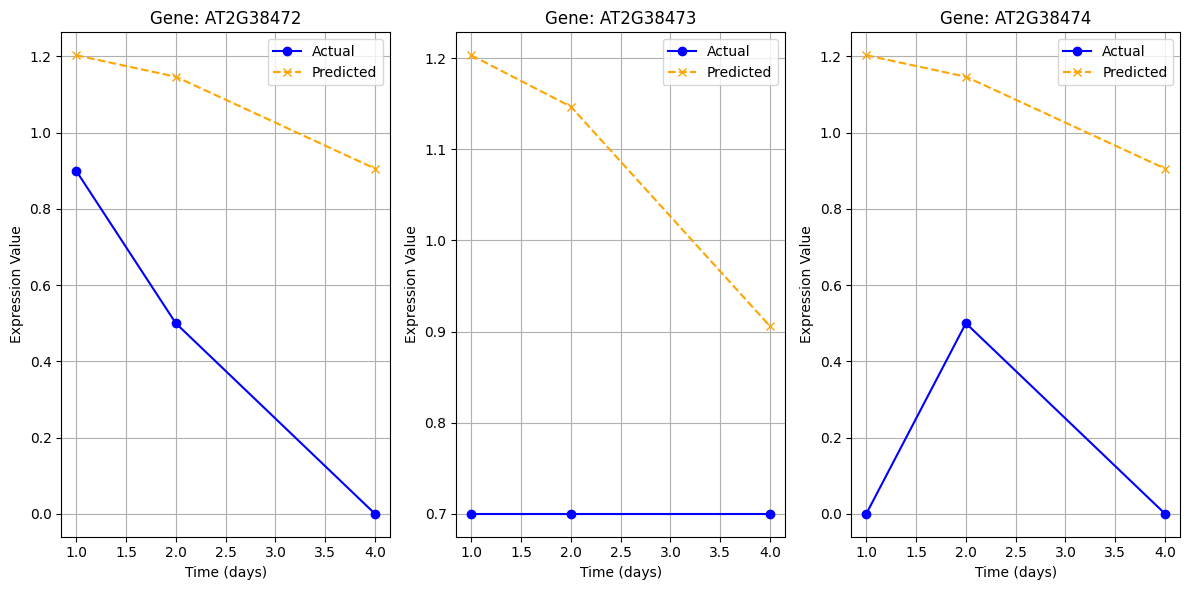

In [ ]:
import matplotlib.pyplot as plt

# Test data
test_expression_values = np.array([
    [0.9, 0.5, 0.0],  # AT2G38472
    [0.7, 0.7, 0.7],  # AT2G38473
    [0.0, 0.5, 0.0],  # AT2G38474
], dtype=np.float32)

# Predict x(t) for the test data using the trained PINN
test_time_points = np.array([1, 2, 4], dtype=np.float32).reshape(-1, 1)
predicted_test_values = model(test_time_points).numpy()


# Print the test predictions
print("Test Predictions (Predicted):")
print(predicted_test_values)

print("\nTest Data (Actual):")
print(test_expression_values.T)  # Transpose for direct comparison



# Plot predictions vs. actual data
gene_labels = ["AT2G38472", "AT2G38473", "AT2G38474"]

plt.figure(figsize=(12, 6))

for i, gene in enumerate(gene_labels):
    plt.subplot(1, 3, i + 1)  # Create subplots for each gene
    plt.plot(test_time_points, test_expression_values[i], 'o-', label="Actual", color="blue")
    plt.plot(test_time_points, predicted_test_values[:, 0], 'x--', label="Predicted", color="orange")
    plt.title(f"Gene: {gene}")
    plt.xlabel("Time (days)")
    plt.ylabel("Expression Value")
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()


In [12]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# import numpy as np
# import scipy.io
# import time
# import torch.autograd as autograd  # This import was missing

# # Set the default dtype to float32
# torch.set_default_dtype(torch.float)

# # Set device configuration
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# print(device)

# if device == 'cuda':
#     print(torch.cuda.get_device_name())

# # ODE Constants
# lambda1 = 2.0
# lambda2 = 0.2

# # Data (Time dependent)
# data = {
#     'AT2G38470': [0.906000416, 0.906000416, 0.906000416]  # example data
# }

# # Time variable
# t = np.linspace(0, 1, 100)  # Example time points

# # Define the ODE function (for example purposes, we use a simple ODE form)
# def ode(t, u, lambda1, lambda2):
#     return lambda1 * u - lambda2 * u ** 2

# # Define the neural network for the inverse PINN
# class DNN(nn.Module):
#     def __init__(self, layers):
#         super(DNN, self).__init__()
#         self.activation = nn.Tanh()
#         self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])

#         for i in range(len(layers)-1):
#             nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
#             nn.init.zeros_(self.linears[i].bias.data)

#     def forward(self, x):
#         a = x
#         for i in range(len(self.linears)-1):
#             z = self.linears[i](a)
#             a = self.activation(z)
#         a = self.linears[-1](a)
#         return a

# # Inverse PINN Class
# class PINN:
#     def __init__(self, layers):
#         self.loss_function = nn.MSELoss(reduction='mean')
#         self.lambda1 = torch.tensor([lambda1], requires_grad=True).float().to(device)
#         self.lambda2 = torch.tensor([lambda2], requires_grad=True).float().to(device)
#         self.dnn = DNN(layers).to(device)

#     def loss_data(self, t, u_data):
#         u_pred = self.dnn(t)
#         loss_u = self.loss_function(u_pred, u_data)
#         return loss_u

#     def loss_ODE(self, t):
#         u = self.dnn(t)
#         u_t = autograd.grad(u, t, torch.ones(t.shape).to(device), retain_graph=True)[0]

#         f = u_t - (self.lambda1 * u - self.lambda2 * u ** 2)
#         loss_ODE = self.loss_function(f, torch.zeros_like(f))
#         return loss_ODE

#     def loss(self, t, u_data):
#         loss_u = self.loss_data(t, u_data)
#         loss_ODE = self.loss_ODE(t)
#         return loss_u + loss_ODE

#     def closure(self):
#         optimizer.zero_grad()
#         loss = self.loss(t_train, u_train)
#         loss.backward()
#         return loss

#     def test(self, t_true, u_true):
#         u_pred = self.dnn(t_true)
#         error = torch.linalg.norm(u_true - u_pred, 2) / torch.linalg.norm(u_true, 2)
#         return error, u_pred

# # Initialize PINN
# layers = [1, 20, 20, 20, 1]  # Example architecture: 1 input (time), 1 output (solution)
# pinn = PINN(layers)

# # Optimizer (L-BFGS)
# optimizer = torch.optim.LBFGS(list(pinn.dnn.parameters()) + [pinn.lambda1, pinn.lambda2], lr=1e-1)

# # Create training data tensors and move to device
# t_train = torch.from_numpy(t).float().to(device).unsqueeze(1)
# # Enable gradient tracking for t_train
# t_train.requires_grad = True
# u_train = torch.tensor([data['AT2G38470'][0]] * len(t), dtype=torch.float32).to(device)


# # Train the model
# start_time = time.time()
# optimizer.step(pinn.closure)
# elapsed = time.time() - start_time
# print(f'Training time: {elapsed:.2f} seconds')

# # Test the model
# t_true = torch.from_numpy(t).float().to(device).unsqueeze(1)
# # Enable gradient tracking for t_true as well
# t_true.requires_grad = True
# u_true = torch.tensor([data['AT2G38470'][0]] * len(t), dtype=torch.float32).to(device)  # True solution
# error, u_pred = pinn.test(t_true, u_true)

# print(f'Test error: {error.item():.5f}')

Epoch 0, Loss: 8.538158
Epoch 500, Loss: 0.000001
Epoch 1000, Loss: 0.000000
Epoch 1500, Loss: 0.000000
Epoch 2000, Loss: 0.000000
Epoch 2500, Loss: 0.003376
Epoch 3000, Loss: 0.000000
Epoch 3500, Loss: 0.000000
Epoch 4000, Loss: 0.000001
Epoch 4500, Loss: 0.000000
Estimated parameters:
k: -0.197881, c: -0.137929


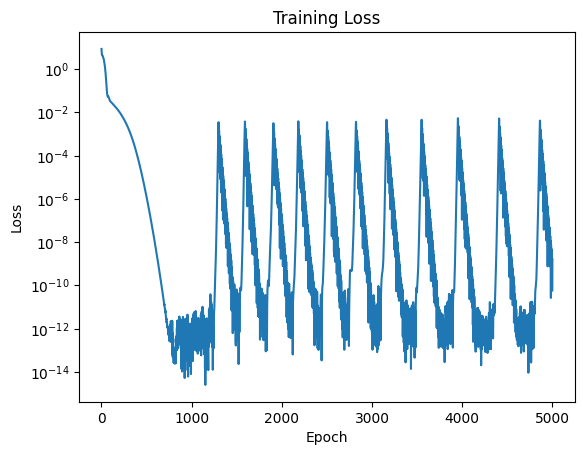

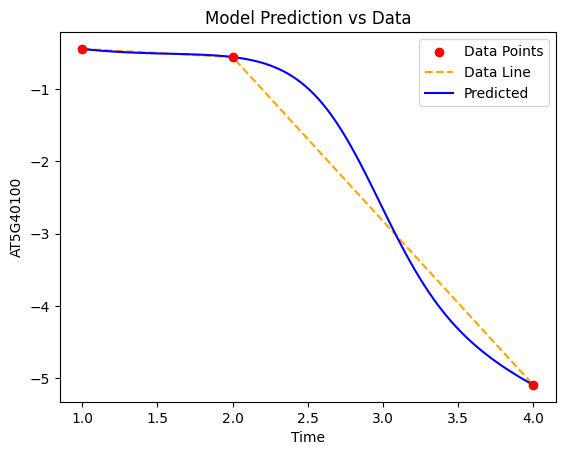

In [21]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Given data
time_points = torch.tensor([1.0, 2.0, 4.0], dtype=torch.float32).view(-1, 1)
data_values = torch.tensor([-0.44796, -0.56015, -5.09196], dtype=torch.float32).view(-1, 1)

# Neural Network for PINN
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.hidden = nn.Sequential(
            nn.Linear(1, 20),
            nn.Tanh(),
            nn.Linear(20, 20),
            nn.Tanh(),
            nn.Linear(20, 1)
        )
        # Parameters to estimate
        self.k = nn.Parameter(torch.tensor(0.1, requires_grad=True))
        self.c = nn.Parameter(torch.tensor(0.1, requires_grad=True))

    def forward(self, t):
        return self.hidden(t)

# Physics-Informed Loss Function
def loss_function(model, t, y_true):
    # Data loss
    y_pred = model(t)
    data_loss = torch.mean((y_pred - y_true) ** 2)

    # Physics loss
    # y_pred.requires_grad = True
    t = t.clone().requires_grad_(True)
    y_pred = model(t)
    dy_dt = torch.autograd.grad(y_pred, t, grad_outputs=torch.ones_like(y_pred), create_graph=True)[0]
    physics_loss = torch.mean((dy_dt + model.k * y_pred - model.c) ** 2)
    return data_loss + physics_loss

# Model, Optimizer, and Training Setup
model = PINN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training loop
num_epochs = 5000
loss_history = []
for epoch in range(num_epochs):
    optimizer.zero_grad()
    loss = loss_function(model, time_points, data_values)
    loss.backward()
    optimizer.step()

    loss_history.append(loss.item())
    if epoch % 500 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.6f}")

# Results
print("Estimated parameters:")
print(f"k: {model.k.item():.6f}, c: {model.c.item():.6f}")

# Plot Loss History
plt.plot(loss_history)
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

# Plot Prediction vs Data
# Plot given data points
plt.scatter(time_points.numpy(), data_values.numpy(), label='Data Points', color='red', zorder=5)
plt.plot(time_points.numpy(), data_values.numpy(), label='Data Line', color='orange', linestyle='--')

# Plot model prediction
t_fine = torch.linspace(1, 4, 100).view(-1, 1)
y_pred_fine = model(t_fine).detach().numpy()
plt.plot(t_fine.numpy(), y_pred_fine, label='Predicted', color='blue')

plt.xlabel('Time')
plt.ylabel('AT5G40100')
plt.title('Model Prediction vs Data')
plt.legend()
plt.show()


Epoch 0, Loss: 0.051316
Epoch 500, Loss: 0.000006
Epoch 1000, Loss: 0.000000
Epoch 1500, Loss: 0.000000
Epoch 2000, Loss: 0.000073
Epoch 2500, Loss: 0.000009
Epoch 3000, Loss: 0.000000
Epoch 3500, Loss: 0.000000
Epoch 4000, Loss: 0.000000
Epoch 4500, Loss: 0.000003
Estimated parameters:
k: -0.397690, c: -0.128836


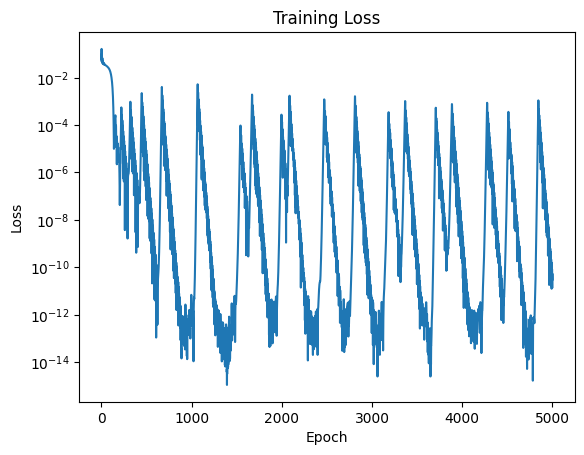

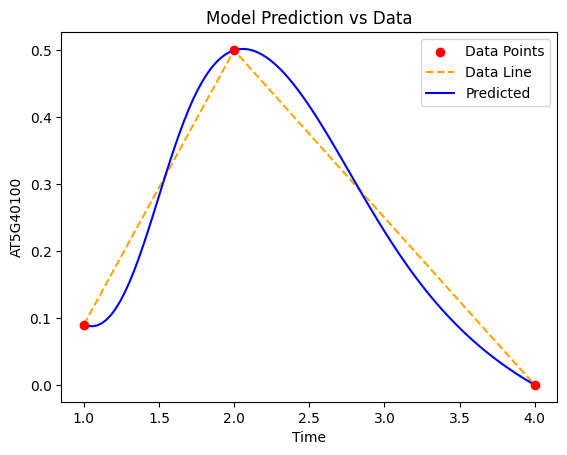

In [22]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Given data
time_points = torch.tensor([1.0, 2.0, 4.0], dtype=torch.float32).view(-1, 1)
data_values = torch.tensor([.09, 0.5, 0.0], dtype=torch.float32).view(-1, 1)

# Neural Network for PINN
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.hidden = nn.Sequential(
            nn.Linear(1, 20),
            nn.Tanh(),
            nn.Linear(20, 20),
            nn.Tanh(),
            nn.Linear(20, 1)
        )
        # Parameters to estimate
        self.k = nn.Parameter(torch.tensor(0.1, requires_grad=True))
        self.c = nn.Parameter(torch.tensor(0.1, requires_grad=True))

    def forward(self, t):
        return self.hidden(t)

# Physics-Informed Loss Function
def loss_function(model, t, y_true):
    # Data loss
    y_pred = model(t)
    data_loss = torch.mean((y_pred - y_true) ** 2)

    # Physics loss
    # y_pred.requires_grad = True
    t = t.clone().requires_grad_(True)
    y_pred = model(t)
    dy_dt = torch.autograd.grad(y_pred, t, grad_outputs=torch.ones_like(y_pred), create_graph=True)[0]
    physics_loss = torch.mean((dy_dt + model.k * y_pred - model.c) ** 2)
    return data_loss + physics_loss

# Model, Optimizer, and Training Setup
model = PINN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training loop
num_epochs = 5000
loss_history = []
for epoch in range(num_epochs):
    optimizer.zero_grad()
    loss = loss_function(model, time_points, data_values)
    loss.backward()
    optimizer.step()

    loss_history.append(loss.item())
    if epoch % 500 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.6f}")

# Results
print("Estimated parameters:")
print(f"k: {model.k.item():.6f}, c: {model.c.item():.6f}")

# Plot Loss History
plt.plot(loss_history)
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

# Plot Prediction vs Data
# Plot given data points
plt.scatter(time_points.numpy(), data_values.numpy(), label='Data Points', color='red', zorder=5)
plt.plot(time_points.numpy(), data_values.numpy(), label='Data Line', color='orange', linestyle='--')

# Plot model prediction
t_fine = torch.linspace(1, 4, 100).view(-1, 1)
y_pred_fine = model(t_fine).detach().numpy()
plt.plot(t_fine.numpy(), y_pred_fine, label='Predicted', color='blue')

plt.xlabel('Time')
plt.ylabel('AT5G40100')
plt.title('Model Prediction vs Data')
plt.legend()
plt.show()
